In [4]:
import torch
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from tqdm.notebook import tqdm
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
from torchvision import transforms

In [5]:
# UNet Components
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], 1)
        return self.conv(x)

In [6]:
# UNet Model
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)

        b = self.bottle_neck(p4)

        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)

        out = self.out(up_4)
        return out

In [7]:
# Dataset Preparation
class CarvanaDataset(Dataset):
    def __init__(self, root_path, test=False):
        self.root_path = root_path
        if test:
            self.images = sorted([root_path + "/manual_test/" + i for i in os.listdir(root_path + "/manual_test/")])
            self.masks = sorted([root_path + "/manual_test_masks/" + i for i in os.listdir(root_path + "/manual_test_masks/")])
        else:
            self.images = sorted([root_path + "/train_images/" + i for i in os.listdir(root_path + "/train_images/")])
            self.masks = sorted([root_path + "/train_masks/" + i for i in os.listdir(root_path + "/train_masks/")])
        
        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor()])

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert("RGB")
        mask = Image.open(self.masks[index]).convert("L")

        return self.transform(img), self.transform(mask)

    def __len__(self):
        return len(self.images)

In [8]:
# Training the Model
LEARNING_RATE = 3e-4
BATCH_SIZE = 4
EPOCHS = 2
DATA_PATH = "/kaggle/input/carvana-image-masking-png"
MODEL_SAVE_PATH = "/kaggle/working/unet.pth"

device = "cuda" if torch.cuda.is_available() else "cpu"
train_dataset = CarvanaDataset(DATA_PATH)

generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(train_dataset, [int(0.8 * len(train_dataset)), len(train_dataset) - int(0.8 * len(train_dataset))], generator=generator)

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

model = UNet(in_channels=3, num_classes=1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

for epoch in tqdm(range(EPOCHS), desc="Epochs"):
    model.train()
    train_running_loss = 0
    for idx, img_mask in enumerate(tqdm(train_dataloader, desc="Training", leave=False)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)

        y_pred = model(img)
        optimizer.zero_grad()

        loss = criterion(y_pred, mask)
        train_running_loss += loss.item()
        
        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / (idx + 1)

    model.eval()
    val_running_loss = 0
    with torch.no_grad():
        for idx, img_mask in enumerate(tqdm(val_dataloader, desc="Validation", leave=False)):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].float().to(device)
            
            y_pred = model(img)
            loss = criterion(y_pred, mask)

            val_running_loss += loss.item()

        val_loss = val_running_loss / (idx + 1)

    print("-" * 30)
    print(f"Train Loss EPOCH {epoch + 1}: {train_loss:.4f}")
    print(f"Valid Loss EPOCH {epoch + 1}: {val_loss:.4f}")
    print("-" * 30)

torch.save(model.state_dict(), MODEL_SAVE_PATH)

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/1018 [00:00<?, ?it/s]

Validation:   0%|          | 0/255 [00:00<?, ?it/s]

------------------------------
Train Loss EPOCH 1: 0.0119
Valid Loss EPOCH 1: 0.0057
------------------------------


Training:   0%|          | 0/1018 [00:00<?, ?it/s]

Validation:   0%|          | 0/255 [00:00<?, ?it/s]

------------------------------
Train Loss EPOCH 2: 0.0055
Valid Loss EPOCH 2: 0.0055
------------------------------


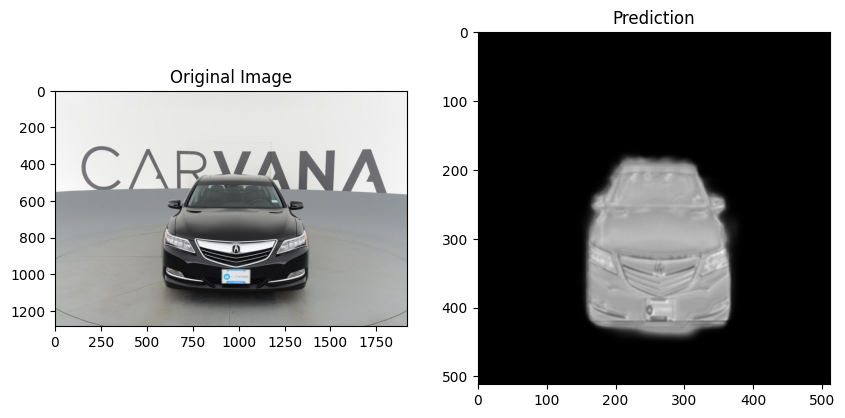

In [9]:
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

def load_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)  # Add batch dimension

def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        output = model(image_tensor)
        output = torch.sigmoid(output)
        output = output.squeeze().cpu().numpy()
    return output

def display_results(image_path, prediction):
    image = Image.open(image_path)
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image)
    
    plt.subplot(1, 2, 2)
    plt.title("Prediction")
    plt.imshow(prediction, cmap='gray')
    
    plt.show()

# Load your trained model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet(in_channels=3, num_classes=1).to(device)
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))

# Test on a single image
image_path = "/kaggle/input/carvana-image-masking-png/train_images/00087a6bd4dc_01.jpg"  
image_tensor = load_image(image_path)
prediction = predict(model, image_tensor, device)

# Display the results
display_results(image_path, prediction)